In [19]:
from gensim.models import Word2Vec
import tensorflow as tf
import os
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [20]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [21]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_model_word2vec = os.path.join(parent_dir[0], "Pre-processamento\\model_word2vec.model")

# Carrega o modelo Word2Vec para um arquivo
model_word2vec = Word2Vec.load(caminho_model_word2vec)

In [22]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

print("max_length: ", max_length)

max_length:  3835


In [23]:
# Carrega dataframe salvo em formato pickle
caminho_noticias = os.path.join(parent_dir[0],"Pre-processamento\\df_pre_processado.pkl")

with open(caminho_noticias, 'rb') as f:
    df = pickle.load(f)

df

,Texto,Categoria,label
0,"[poder, decidir, expulsar, deputado, federal, ...",Real,1
1,"[bolsonaro, liberal, completo, presidente, psl...",Real,1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",Real,1
3,"[apesar, abundancia, crescer, preocupacao, pre...",Real,1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",Real,1
...,...,...,...
22279,"[encontrar, reunir, presidente, jair, Bolsonar...",Falso,0
22280,"[reabertura, complexo, parque, disney, orlar, ...",Falso,0
22281,"[publicacao, circular, rede, social, pedir, mi...",Real,1
22282,"[juiz, Wauner, Batista, Ferreiro, machadar, va...",Falso,0


In [24]:
# Carrega os rótulos (labels) de um arquivo pickle
caminho_labels = os.path.join(parent_dir[0],"Pre-processamento\\labels.pkl")
with open(caminho_labels, 'rb') as f:
    labels = pickle.load(f)

In [25]:
# Carrega os dados de treino de um arquivo pickle
caminho_treino = os.path.join(parent_dir[0],"Pre-processamento\\train_data.pkl")
with open(caminho_treino, 'rb') as f:
    X_train, y_train = pickle.load(f)

print("Dados treinamento carregados: ", X_train, y_train)

# Carrega os dados de validação de um arquivo pickle
caminho_validacao = os.path.join(parent_dir[0],"Pre-processamento\\val_data.pkl")
with open(caminho_validacao, 'rb') as f:
    X_val, y_val = pickle.load(f)

print("Dados validação carregados: ", X_val, y_val)

# Carrega os dados de teste de um arquivo pickle
caminho_teste = os.path.join(parent_dir[0],"Pre-processamento\\test_data.pkl")
with open(caminho_teste, 'rb') as f:
    X_test, y_test = pickle.load(f)

print("Dados teste carregados: ", X_test, y_test)

Dados treinamento carregados:  [[  351   565    67 ...     0     0     0]
 [   66 78330   318 ...     0     0     0]
 [ 2431  2404   579 ...     0     0     0]
 ...
 [  229 12291  1054 ...     0     0     0]
 [12618  9196   670 ... 26460     1   121]
 [    2  2597  7549 ...     0     0     0]] [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Dados validação carregados:  [[ 216   29    1 ...    0    0    0]
 [  63   13 3150 ...    0    0    0]
 [ 548  454  296 ...    0    0    0]
 ...
 [ 636 5280   88 ...    0    0    0]
 [6776  158 3653 ...    0    0    0]
 [2863  100  194 ...    0    0    0]] [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Dados teste carregados:  [[ 138   48   26 ...    0    0    0]
 [   2  312 3701 ...    0    0    0]
 [1882 1627   50 ...    0    0    0]
 ...
 [  14  762  174 ...    0    0    0]
 [  41   76 4954 ...    0    0    0]
 [ 138   48   26 ...    0    0    0]] [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [26]:
# Cria modelo Stacked LSTM
model = Sequential()

# Adicionando a camada de Embedding para representação de palavras
model.add(Embedding(input_dim=len(model_word2vec.wv.key_to_index) + 1, 
                    output_dim=model_word2vec.vector_size))

# Adicionando a primeira camada LSTM com retorno de sequências
model.add(LSTM(units=64, return_sequences=True))
# Adicionando regularização Dropout
model.add(Dropout(0.2))

# Adicionando a segunda camada LSTM sem retorno de sequências
model.add(LSTM(units=32, return_sequences=False))
# Adicionando regularização Dropout
model.add(Dropout(0.2))

# Adicionando a camada densa de saída com ativação softmax para classificação
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Configurando parada precoce baseada na perda de validação
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# Compilando o modelo com função de perda, otimizador e métricas
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo com dados de treinamento e validação, usando parada precoce como callback
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
244/244 [==============================] - 38s 143ms/step - loss: 0.6751 - accuracy: 0.5586 - val_loss: 0.6536 - val_accuracy: 0.5788
Epoch 2/40
244/244 [==============================] - 33s 136ms/step - loss: 0.6918 - accuracy: 0.5603 - val_loss: 0.7135 - val_accuracy: 0.4669
Epoch 3/40
244/244 [==============================] - 34s 138ms/step - loss: 0.7006 - accuracy: 0.5172 - val_loss: 0.6724 - val_accuracy: 0.5743
Epoch 4/40
244/244 [==============================] - 33s 137ms/step - loss: 0.6691 - accuracy: 0.5421 - val_loss: 0.6553 - val_accuracy: 0.5761
Epoch 5/40
244/244 [==============================] - 33s 136ms/step - loss: 0.6632 - accuracy: 0.5556 - val_loss: 0.6595 - val_accuracy: 0.5743


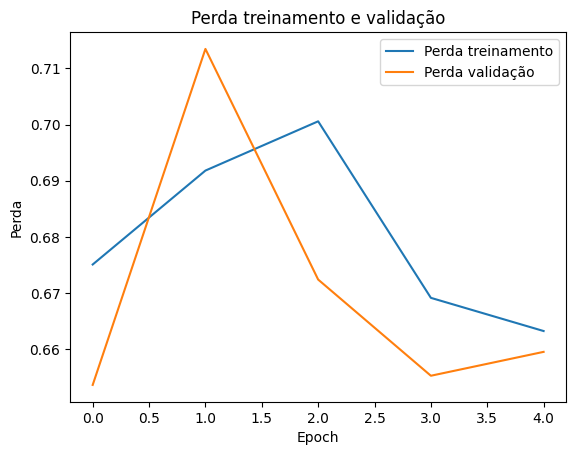

In [27]:
# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda treinamento')
plt.plot(history.history['val_loss'], label='Perda validação')
plt.title('Perda treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [28]:
# Salva os arquivos
model.save('LSTMStacked_model.h5')
np.save("X_test_LSTMStacked.npy", X_test)
np.save("y_test_LSTMStacked.npy", y_test)